# <h1><center>Spatial Data Science </center></h1>
   ## <h1><center>Spatial Data Science : Proximity Analysis and interactive data visualization on map view</center></h1>


#### Importing following libraries for achieving a proximity analysis between old and new sites data and then rendering them on an interactive map view

In [2]:
import geopandas as gpd
import folium
import pandas as pd
from shapely.ops import nearest_points
from shapely.geometry import LineString
import random
import string

#### Reading an existing analyzed shape file data using geopandas read_file function to render it using Folium

In [3]:
old_sites = pd.read_excel("data/Copy of Budget Sites.xlsx",sheet_name='old_fibre_sites')
new_sites = pd.read_excel("data/Copy of Budget Sites.xlsx",sheet_name='New_Sites')

In [4]:
old_sites.to_csv("data/Budget Sites.csv",index=None,header=True) 

new_sites.to_csv("data/Budget Sites new.csv",index=None,header=True) 

In [6]:
new_sites_csv= pd.read_csv("data/Budget Sites new.csv")
old_sites_csv= pd.read_csv("data/Budget Sites.csv")

In [5]:
new_sites_csv.head()
new_sites_csv.shape


In [1]:
old_sites_csv.head()
old_sites_csv.shape


#### Correcting Column in the dataframes

In [3]:
new_sites_csv = new_sites_csv.rename(columns={'Site Name':'NEW_SITE_NAME'})
new_sites_csv.head()
new_sites_csv.shape


In [4]:
old_sites_csv = old_sites_csv.rename(columns={'LRP RAN Site name':'OLD_SITE_NAME'})
old_sites_csv.head()
old_sites_csv.shape


#### Replacing values of columns using a random string

In [11]:
N=7
res= ''.join(random.choices(string.ascii_uppercase+string.digits,k=N))
res

'1BXEOQV'

In [12]:
  def gen_str(N=7,char=string.ascii_uppercase+string.digits):
        return ''.join(random.choice(char) for i in range(N))
    
    #new_sites.replace(to_replace=new_sites['SITE_ID'].values,value=''.join(random.choices(string.ascii_uppercase+string.digits,k=N)),inplace=True)
gen_str()


'0RQ4V6A'

In [16]:
old_sites_csv.replace(to_replace=old_sites_csv['OLD_SITE_NAME'].values,value=gen_str(),inplace=True)
old_sites_csv.replace(to_replace=old_sites_csv['Vendor'].values,value=gen_str(),inplace=True)
old_sites_csv.replace(to_replace=old_sites_csv['Region'].values,value=gen_str(),inplace=True)

In [19]:
new_sites_csv.replace(to_replace=new_sites_csv['NEW_SITE_NAME'].values,value=gen_str(),inplace=True)
new_sites_csv.replace(to_replace=new_sites_csv['Site ID'].values,value=gen_str(),inplace=True)
new_sites_csv.replace(to_replace=new_sites_csv['Region'].values,value=gen_str(),inplace=True)

In [6]:
new_sites_csv.head()


In [7]:
old_sites_csv.head()


#### Transforming a panda dataframe into a geopanda data frame by creating a point geometry of coordinates supplied

In [23]:
old_sites_df= gpd.GeoDataFrame(old_sites_csv,geometry=gpd.points_from_xy(old_sites_csv['Longitude'],old_sites_csv['Latitude']),crs='epsg:4326')

In [8]:
old_sites_df.head()

<AxesSubplot:>

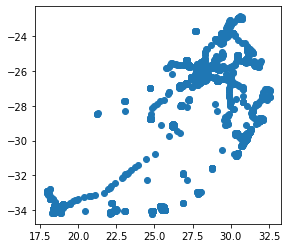

In [23]:
old_sites_df.plot()

In [24]:
old_sites_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
new_sites_df= gpd.GeoDataFrame(new_sites_csv,geometry=gpd.points_from_xy(new_sites_csv['Long'],new_sites_csv['Lat']),crs='epsg:4326')

#### Removing null values if any from dataframe

In [9]:
old_sites_df.isnull().sum()


In [28]:
old_sites_df=old_sites_df.dropna()

In [8]:
old_sites_df.isnull().sum()


In [7]:
new_sites_df.isnull().sum()


#### Calulating nearest neighbour ,then generating a line geometry between the two point geometries within a 1200 meter distance between two points

In [31]:
#changing crs to the one having unit as meters such as 3857
new_sites_df_meters=new_sites_df.to_crs(epsg=3857)
new_sites_df_meters.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
old_sites_df_meters=old_sites_df.to_crs(epsg=3857)
old_sites_df_meters.head()


In [33]:
#defining a method to calculate nearest geometry making use of unary_union
def calculate_nearest(df, destination, val, col='geometry'):
    dest_unary = destination.unary_union
    nearest_geom = nearest_points(df[col], dest_unary)
    geom_match = destination.loc[destination.geometry == nearest_geom[1]]
    matched_value = geom_match[val].to_numpy()[0]
    return matched_value

In [10]:
#adding a new column with the nearest geometry value obtained by application of above method
new_sites_df_meters["nearest_geometry"] = new_sites_df_meters.apply(calculate_nearest, destination=old_sites_df_meters, val="geometry", axis=1)
new_sites_df_meters.head()


In [11]:
#adding a new column that will represent the nearest old site name close to the corrsponding new site
new_sites_df_meters["nearest_old_site"] = new_sites_df_meters.apply(calculate_nearest, destination=old_sites_df_meters, val="OLD_SITE_NAME", axis=1)
new_sites_df_meters.head()


In [1]:
#creating a line geometry column in new site dataframe 
new_sites_df_meters['line'] = new_sites_df_meters.apply(lambda row: LineString([row['geometry'], row['nearest_geometry']]), axis=1)

new_sites_df_meters.shape


In [37]:
#defining a method to add distance between corresponding new and old site geometries
def get_distance(row):
    distance = row.geometry.distance(row.nearest_geometry)
    print(distance)
    return distance

In [2]:
#adding a new column in new site df to reflect distance values
new_sites_df_meters['distance'] = new_sites_df_meters.apply(lambda row: get_distance(row), axis=1)


In [3]:
new_sites_df_meters.shape


#### Changing crs back to degree decimal format, enable proper representation making use of folium for interactive map

In [4]:
old_sites_df_wgs84=old_sites_df_meters.to_crs(epsg=4326)
old_sites_df_wgs84.head()


In [12]:
new_sites_df_ws_84=new_sites_df_meters.set_geometry('line')
new_sites_df_ws_84.geom_type
new_sites_df_ws_84.to_crs(epsg=4326)


#### Limiting dataframe values to records where distance is less than 1200 meters

In [13]:
new_sites_df_ws_84=new_sites_df_ws_84[new_sites_df_ws_84['distance'] < 1200]
new_sites_df_ws_84.shape


In [47]:
nearest_line=new_sites_df_ws_84[['Site ID','nearest_old_site','line','distance']].set_geometry('line')

In [48]:
nearest_line_wgs84=nearest_line.to_crs(epsg=4326)
nearest_line_wgs84.geometry

0       LINESTRING (27.98458 -26.23383, 27.98444 -26.2...
1       LINESTRING (27.92860 -26.09040, 27.92657 -26.0...
6       LINESTRING (29.09441 -26.52435, 29.09303 -26.5...
7       LINESTRING (29.08761 -26.52625, 29.09303 -26.5...
8       LINESTRING (29.08690 -26.53715, 29.08644 -26.5...
                              ...                        
2547    LINESTRING (28.27764 -25.78084, 28.27727 -25.7...
2557    LINESTRING (18.46207 -33.96623, 18.46447 -33.9...
2567    LINESTRING (20.86338 -33.19453, 20.85935 -33.1...
2604    LINESTRING (22.95397 -32.07545, 22.95164 -32.0...
2615    LINESTRING (31.03505 -29.83654, 31.03508 -29.8...
Name: line, Length: 1115, dtype: geometry

#### buffer of 1200 meters 

In [5]:
nearest_line_wgs84=nearest_line_wgs84[nearest_line_wgs84['distance'] < 1200]
nearest_line_wgs84.shape


<AxesSubplot:>

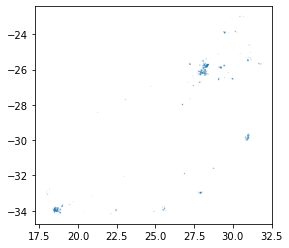

In [50]:
nearest_line_wgs84.plot()

In [259]:
nearest_line_wgs84=nearest_line_wgs84.rename(columns={'distance':'Distance in meters: '})

In [6]:
nearest_line_wgs84.shape


In [15]:
new_sites_df_ws_84.crs
new_sites_df_ws_84=new_sites_df_ws_84.set_geometry('geometry')
new_sites_df_ws_84=new_sites_df_ws_84.to_crs(epsg=4326)
new_sites_df_ws_84.geometry
new_sites_df_ws_84.head()
new_sites_df_ws_84.shape


In [14]:
new_sites_df_ws_84=new_sites_df_ws_84.to_crs(epsg=4326)
new_sites_df_ws_84.head()


#### Setting map location as per requirement for example South Africa 

In [46]:
m = folium.Map(location= [-28.4792625,24.6727135],zoom_start=6)
m

####  Visualization of data on Map

In [225]:
labels_new = list(new_sites_df_ws_84.NEW_SITE_NAME)
x_coord = list(new_sites_df_ws_84.geometry.x)
y_coord = list(new_sites_df_ws_84.geometry.y)
m = folium.Map([-28.4792625,24.6727135], zoom_start=5, tiles='cartodbpositron')
for lat,lon,labels_new in zip(y_coord,x_coord,labels_new):
    folium.Circle(location=[lat,lon],color='green', radius=0.19,popup=labels_new).add_to(m)
m
m.save('new_sites_using_csv.html')


In [266]:

m = folium.Map([-28.4792625,24.6727135], zoom_start=5, tiles='cartodbpositron')
style = {'fillColor': 'black', 'color': 'black'}
folium.GeoJson(nearest_line_wgs84.sample(1000),style_function=lambda x: style,popup=folium.GeoJsonPopup(fields=['Distance in meters: ']),tooltip=folium.GeoJsonTooltip(fields=['Distance in meters: '])).add_to(m)
m
#m.save('line.html')

#### Data visualization on an interactive map view showing data with useful information in tooltip,color and location

In [269]:
m = folium.Map([-28.4792625,24.6727135], zoom_start=5, tiles='Stamen Terrain')
#We want to add site name as a tooltip so for this we will create a list as shown below
labels_new = list(new_sites_df_ws_84.NEW_SITE_NAME)
x_coord = list(new_sites_df_ws_84.geometry.x)
y_coord = list(new_sites_df_ws_84.geometry.y)

for lat,lon,labels_new in zip(y_coord,x_coord,labels_new):
    folium.Circle(location=[lat,lon],color='green',fill_color='green', radius=50,popup=labels_new,tooltip=labels_new).add_to(m)

labels_old = list(old_sites_df_wgs84.OLD_SITE_NAME)
x_coord = list(old_sites_df_wgs84.geometry.x)
y_coord = list(old_sites_df_wgs84.geometry.y)

for lat,lon,labels_old in zip(y_coord,x_coord,labels_old):
    folium.Circle(location=[lat,lon],color='red',fill_color='red', radius=50,popup=labels_old,tooltip=labels_old).add_to(m)
#To style line geomtery we need to create a dictionary and use style fucntion lamda,also GeoJsonTooltip provides a way to add tooltip for the line geometry
style = {'fillColor': 'black', 'color': 'black',"stroke-width":0.001,
        "fill-opacity":0.6}
folium.GeoJson(nearest_line_wgs84,popup=folium.GeoJsonPopup(fields=['Distance in meters: ']),style_function=lambda x: style,tooltip=folium.GeoJsonTooltip(fields=['Distance in meters: '])).add_to(m)

folium.TileLayer('openstreetmap').add_to(m)

folium.LayerControl().add_to(m)

m.save('data_analysis_map_using_csv.html')

In [275]:
# Marker Cluster

x_coord = list(new_sites_df_ws_84.geometry.x)
y_coord = list(new_sites_df_ws_84.geometry.y)



x1_coord = list(old_sites_df_wgs84.geometry.x)
y1_coord = list(old_sites_df_wgs84.geometry.y)

from folium.plugins import FastMarkerCluster

m1 = folium.Map(location=[-28.4792625,24.6727135],
                        zoom_start=2,
                        tiles='CartoDB dark_matter')

callback_new = """\
function (row) {
var icon, marker;
icon = L.AwesomeMarkers.icon({
icon: "map-marker", markerColor: "green"});
marker = L.marker(new L.LatLng(row[0], row[1]));
marker.setIcon(icon);
return marker;
};
"""
callback_old = """\
function (row) {
var icon, marker;
icon = L.AwesomeMarkers.icon({
icon: "map-marker", markerColor: "red"});
marker = L.marker(new L.LatLng(row[0], row[1]));
marker.setIcon(icon);
return marker;
};
"""

FastMarkerCluster(zip(y_coord,x_coord),callback=callback_new).add_to(m1)
FastMarkerCluster(zip(y1_coord,x1_coord),callback=callback_old).add_to(m1)

folium.TileLayer('openstreetmap').add_to(m1)
folium.TileLayer('cartodbpositron').add_to(m1)
folium.LayerControl().add_to(m1)
m1.save('data_analysis_map_cluster_from_csv.html')